In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


In [3]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp25.csv', header=None)


In [4]:
#count rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    1048574
dtype: int64


In [5]:
#actual recording time 57 mins = 3420s
#3420*64=n_rows
n_of_rows_keep = 3420*64
print(n_of_rows_keep)

218880


In [6]:
#using pandas to drop all the rows / seconds after 3540s 
#[n_of_rows_keep:n_of_rows]
df_BVP = df_BVP.drop(df_BVP.index[218880:1048574])
print(df_BVP)

            0
0        0.00
1        0.00
2        0.00
3        0.00
4        0.00
...       ...
218875  12.12
218876  12.49
218877  12.19
218878  10.99
218879   8.79

[218880 rows x 1 columns]


In [7]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)


0    218880
dtype: int64
0    3420.0
dtype: float64
0    57.0
dtype: float64


In [8]:
#create BVP signal 
fsamp = 64  #64 Hz 
t_start = 0

ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')

In [9]:
print(ecg.get_start_time())

0


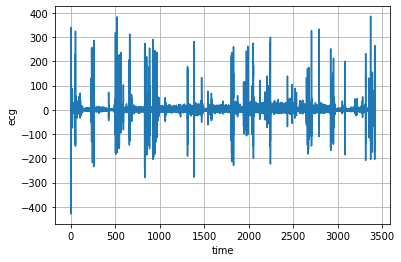

In [10]:
ecg.plot()

In [11]:
ibi = ph.BeatFromECG()(ecg)

In [12]:
ibi.get_duration() #seconds 

3420.0

In [13]:
# create label
label = np.zeros(3420)
label[0:600] =1
label[600:3420] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [14]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [15]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [16]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

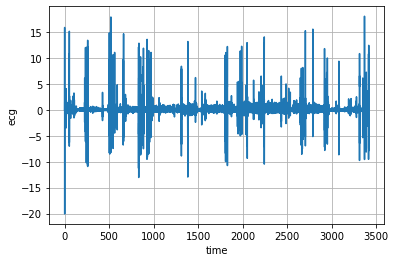

In [17]:
ecg.plot()

In [28]:
ibi = ph.BeatFromECG()(ecg)

In [29]:
ibi.get_duration()


3420.0

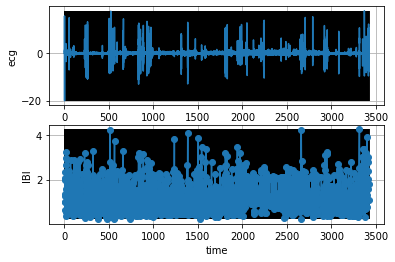

In [30]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [31]:
### physiological indicators 

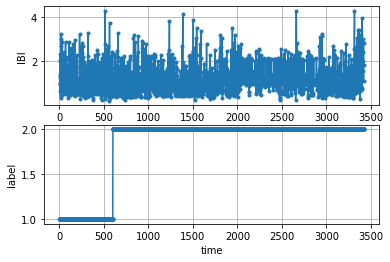

In [32]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()

In [33]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [34]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [35]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1df73290>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1df839d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1df7c2d0>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1df6aed0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1df8a950>,
 'means': []}

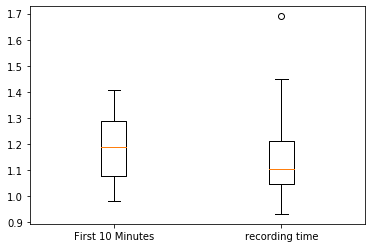

In [36]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 Minutes', 'recording time'])

In [ ]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

In [ ]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [41]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp25_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp25_df

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.232666,61.232666,1.0,291.620808,686.493723,823.955587,2449.331096
1,61.232666,121.232666,1.0,351.652573,912.999101,767.834083,2706.081314
2,121.232666,181.232666,1.0,184.972007,534.563945,949.576460,2370.964757
3,181.232666,241.232666,1.0,224.289673,594.966041,840.715609,2426.202868
4,241.232666,301.232666,1.0,411.024072,781.963391,998.731495,2866.758203
5,301.232666,361.232666,1.0,211.928467,597.607113,708.929580,2284.529184
6,361.232666,421.232666,1.0,158.248513,410.523458,810.132061,2130.612320
7,421.232666,481.232666,1.0,309.051221,632.212128,822.355090,2453.244798
8,481.232666,541.232666,1.0,114.454117,346.923822,574.298221,1678.395130
9,601.232666,661.232666,2.0,236.692940,663.148721,811.792947,2340.203351


In [42]:
#save data 
FD_HRV_pp25_df.to_csv('FD_HRV_pp25.csv')